<a href="https://colab.research.google.com/github/alycialee/cs159_sorb/blob/master/sorb_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# [_Search on the Replay Buffer_: Bridging Planning and Reinforcement Learning](https://arxiv.org/abs/1906.05253)

*Benjamin Eysenbach, Ruslan Salakhutdinov, and Sergey Levine*


What is *SoRB*? *SoRB* is a machine learning algorithm that learns to make decisions to reach goals. Typically, these sorts of control algorithms either rely on planning methods or reinforcement learning methods, both of which have limitations. Planning algorithms can reason over long horizons, but cannot deal with high-dimensional observations. Reinforcement learning algorithms fail to plan over long distances. *SoRB* attempts to combine the best of both algorithms.


<center><img src="http://drive.google.com/uc?export=view&id=1LCqQJb06vyBOHl1uX-bi1p_LvuDMfPIF" 
alt="search on the replay buffer" width="800px"/></center>
The figure above highlights the basic idea.

* (a) Goal-conditioned RL often fails to reach distant goals, but can successfully reach nearby goals (indicated in green).
* (b) Our goal is to use observations in our replay buffer (yellow squares) as waypoints leading to the goal.
* (c) We automatically find these waypoints by using the agent's value function to predict when two states are nearby, and building the corresponding graph.
* (d) We run graph search to find the sequence of waypoints (blue arrows), and then use our goal-conditioned policy to reach each waypoint.

<center><img src="http://drive.google.com/uc?export=view&id=1RsSVVYEcRADJmd78JYLARR0nGJtrpIN9" 
alt="search on the replay buffer" width="400px"/></center>
In our paper, we show how this algorithm can be used to solve complex visual navigation tasks, like the one shown above. In this colab notebook, we implement a basic version of *SoRB* on a simple navigation task. Interactive visualizations below allow you to explore the effect of various hyperparameters, as well as train your own agents.

### Related Work
A number of prior works have proposed methods for learning goal-conditioned policies and combining planning with RL. We encourage you to check out these related works:
* Kaelbling, Leslie Pack. "Learning to achieve goals." IJCAI. 1993.
* Schaul, Tom, et al. "Universal value function approximators." International conference on machine learning. 2015.
* Pong, Vitchyr, et al. "Temporal difference models: Model-free deep rl for model-based control." arXiv preprint arXiv:1802.09081 (2018).
* Francis, Anthony, et al. "Long-Range Indoor Navigation with PRM-RL." arXiv preprint arXiv:1902.09458 (2019).
* Savinov, Nikolay, Alexey Dosovitskiy, and Vladlen Koltun. "Semi-parametric topological memory for navigation." arXiv preprint arXiv:1803.00653 (2018).


If you find this code useful, please consider citing our paper: [https://arxiv.org/abs/1906.05253](https://arxiv.org/abs/1906.05253)
```
@misc{eysenbach2019,
Author = {Benjamin Eysenbach and Ruslan Salakhutdinov and Sergey Levine},
Title = {Search on the Replay Buffer: Bridging Planning and Reinforcement Learning},
Year = {2019},
Eprint = {arXiv:1906.05253},
}
```

### Getting Started
To get started, click the "Connect" button in the top right corner of the screen. You should see a green checkmark next to some stats about RAM and Disk. Run each of the cells below, either by clicking the "run cell" button on the left of each cell, or by pressing [ctrl]+[enter]. **Double click on any cell to see the code.**



In [20]:
#@title Install Dependencies
!pip install tensorflow
!pip install tf-agents

In [0]:
#@title Import dependencies.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import random
import time
import tqdm

import gym
import gym.spaces
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse.csgraph
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment
from tf_agents.environments import wrappers
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import utils
from tf_agents.policies import actor_policy
from tf_agents.policies import ou_noise_policy
from tf_agents.policies import tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import time_step
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
# tf.enable_eager_execution()
# tf.logging.set_verbosity(tf.logging.INFO)

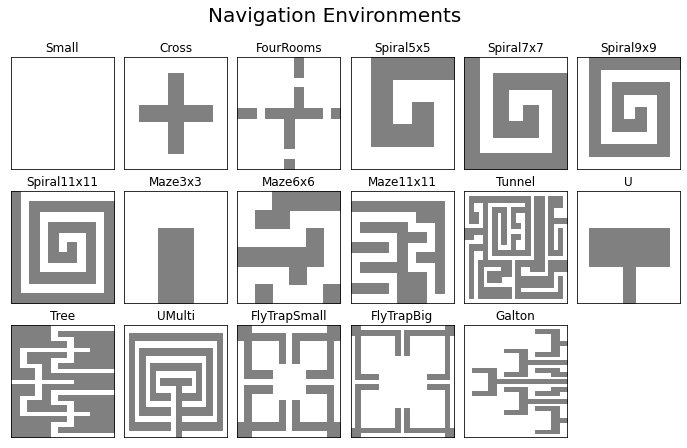

In [22]:
#@title Implement the 2D navigation environment and helper functions.
WALLS = {
    'Small':
        np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]]),
    'Cross':
        np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]]),
    'FourRooms':
        np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]),
    'Spiral5x5':
        np.array([[0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1],
                  [0, 1, 0, 0, 1],
                  [0, 1, 1, 0, 1],
                  [0, 0, 0, 0, 1]]),
    'Spiral7x7':
        np.array([[1, 1, 1, 1, 1, 1, 1],
                  [1, 0, 0, 0, 0, 0, 0],
                  [1, 0, 1, 1, 1, 1, 0],
                  [1, 0, 1, 0, 0, 1, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 0, 0, 0, 0, 1, 0],
                  [1, 1, 1, 1, 1, 1, 0]]),
    'Spiral9x9':
        np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 1, 1],
                  [0, 1, 0, 0, 0, 0, 0, 0, 1],
                  [0, 1, 0, 1, 1, 1, 1, 0, 1],
                  [0, 1, 0, 1, 0, 0, 1, 0, 1],
                  [0, 1, 0, 1, 1, 0, 1, 0, 1],
                  [0, 1, 0, 0, 0, 0, 1, 0, 1],
                  [0, 1, 1, 1, 1, 1, 1, 0, 1],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1]]),
    'Spiral11x11':
        np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
                  [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
                  [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
                  [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]),
    'Maze3x3':
        np.array([[0, 0, 0],
                  [1, 1, 0],
                  [0, 0, 0]]),
    'Maze6x6':
        np.array([[0, 0, 1, 0, 0, 0],
                  [1, 0, 1, 0, 1, 0],
                  [0, 0, 1, 0, 1, 1],
                  [0, 1, 1, 0, 0, 1],
                  [0, 0, 1, 1, 0, 1],
                  [1, 0, 0, 0, 0, 1]]),
    'Maze11x11':
        np.array([[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
                  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
                  [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
                  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
    'Tunnel':
        np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
                  [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
                  [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
                  [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
                  [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
                  [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
                  [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
                  [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]),
    'U':
        np.array([[0, 0, 0],
                  [0, 1, 0],
                  [0, 1, 0],
                  [0, 1, 0],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 1, 0],
                  [0, 1, 0],
                  [0, 0, 0]]),
    'Tree':
        np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
            [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        ]),
    'UMulti':
        np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
            [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         ]),
    'FlyTrapSmall':
        np.array([
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
         ]),
    'FlyTrapBig':
        np.array([
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
         ]),
    'Galton':
        np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        ]),
}

def resize_walls(walls, factor):
  """Increase the environment by rescaling.

  Args:
    walls: 0/1 array indicating obstacle locations.
    factor: (int) factor by which to rescale the environment."""
  (height, width) = walls.shape
  row_indices = np.array([i for i in range(height) for _ in range(factor)])
  col_indices = np.array([i for i in range(width) for _ in range(factor)])
  walls = walls[row_indices]
  walls = walls[:, col_indices]
  assert walls.shape == (factor * height, factor * width)
  return walls



class PointEnv(gym.Env):
  """Abstract class for 2D navigation environments."""

  def __init__(self, walls=None, resize_factor=1,
               action_noise=1.0):
    """Initialize the point environment.

    Args:
      walls: (str) name of one of the maps defined above.
      resize_factor: (int) Scale the map by this factor.
      action_noise: (float) Standard deviation of noise to add to actions. Use 0
        to add no noise.
    """
    if resize_factor > 1:
      self._walls = resize_walls(WALLS[walls], resize_factor)
    else:
      self._walls = WALLS[walls]
    self._apsp = self._compute_apsp(self._walls)
    (height, width) = self._walls.shape
    self._height = height
    self._width = width
    self._action_noise = action_noise
    self.action_space = gym.spaces.Box(
        low=np.array([-1.0, -1.0]),
        high=np.array([1.0, 1.0]),
        dtype=np.float32)
    self.observation_space = gym.spaces.Box(
        low=np.array([0.0, 0.0]),
        high=np.array([self._height, self._width]),
        dtype=np.float32)
    self.reset()

  def _sample_empty_state(self):
    candidate_states = np.where(self._walls == 0)
    num_candidate_states = len(candidate_states[0])
    state_index = np.random.choice(num_candidate_states)
    state = np.array([candidate_states[0][state_index],
                      candidate_states[1][state_index]],
                     dtype=np.float)
    state += np.random.uniform(size=2)
    assert not self._is_blocked(state)
    return state

  def reset(self):
    self.state = self._sample_empty_state()
    return self.state.copy()

  def _get_distance(self, obs, goal):
    """Compute the shortest path distance.

    Note: This distance is *not* used for training."""
    (i1, j1) = self._discretize_state(obs)
    (i2, j2) = self._discretize_state(goal)
    return self._apsp[i1, j1, i2, j2]

  def _discretize_state(self, state, resolution=1.0):
    (i, j) = np.floor(resolution * state).astype(np.int)
    # Round down to the nearest cell if at the boundary.
    if i == self._height:
      i -= 1
    if j == self._width:
      j -= 1
    return (i, j)

  def _is_blocked(self, state):
    if not self.observation_space.contains(state):
      return True
    (i, j) = self._discretize_state(state)
    return (self._walls[i, j] == 1)

  def step(self, action):
    if self._action_noise > 0:
      action += np.random.normal(0, self._action_noise)
    action = np.clip(action, self.action_space.low, self.action_space.high)
    assert self.action_space.contains(action)
    num_substeps = 10
    dt = 1.0 / num_substeps
    num_axis = len(action)
    for _ in np.linspace(0, 1, num_substeps):
      for axis in range(num_axis):
        new_state = self.state.copy()
        new_state[axis] += dt * action[axis]
        if not self._is_blocked(new_state):
          self.state = new_state

    done = False
    rew = -1.0 * np.linalg.norm(self.state)
    return self.state.copy(), rew, done, {}

  @property
  def walls(self):
    return self._walls

  def _compute_apsp(self, walls):
    (height, width) = walls.shape
    g = nx.Graph()
    # Add all the nodes
    for i in range(height):
      for j in range(width):
        if walls[i, j] == 0:
          g.add_node((i, j))

    # Add all the edges
    for i in range(height):
      for j in range(width):
        for di in [-1, 0, 1]:
          for dj in [-1, 0, 1]:
            if di == dj == 0: continue  # Don't add self loops
            if i + di < 0 or i + di > height - 1: continue  # No cell here
            if j + dj < 0 or j + dj > width - 1: continue  # No cell here
            if walls[i, j] == 1: continue  # Don't add edges to walls
            if walls[i + di, j + dj] == 1: continue  # Don't add edges to walls
            g.add_edge((i, j), (i + di, j + dj))

    # dist[i, j, k, l] is path from (i, j) -> (k, l)
    dist = np.full((height, width, height, width), np.float('inf'))
    for ((i1, j1), dist_dict) in nx.shortest_path_length(g):
      for ((i2, j2), d) in dist_dict.items():
        dist[i1, j1, i2, j2] = d
    return dist

class GoalConditionedPointWrapper(gym.Wrapper):
  """Wrapper that appends goal to state produced by environment."""


  def __init__(self, env, prob_constraint=0.8, min_dist=0, max_dist=4,
               threshold_distance=1.0):
    """Initialize the environment.

    Args:
      env: an environment.
      prob_constraint: (float) Probability that the distance constraint is
        followed after resetting.
      min_dist: (float) When the constraint is enforced, ensure the goal is at
        least this far from the initial state.
      max_dist: (float) When the constraint is enforced, ensure the goal is at
        most this far from the initial state.
      threshold_distance: (float) States are considered equivalent if they are
        at most this far away from one another.
    """
    self._threshold_distance = threshold_distance
    self._prob_constraint = prob_constraint
    self._min_dist = min_dist
    self._max_dist = max_dist
    super(GoalConditionedPointWrapper, self).__init__(env)
    self.observation_space = gym.spaces.Dict({
        'observation': env.observation_space,
        'goal': env.observation_space,
    })

  def _normalize_obs(self, obs):
    return np.array([
        obs[0] / float(self.env._height),
        obs[1] / float(self.env._width)
    ])

  def reset(self):
    goal = None
    count = 0
    while goal is None:
      obs = self.env.reset()
      (obs, goal) = self._sample_goal(obs)
      count += 1
      if count > 1000:
        print('WARNING: Unable to find goal within constraints.')
    self._goal = goal
    return {'observation': self._normalize_obs(obs),
            'goal': self._normalize_obs(self._goal)}

  def step(self, action):
    obs, _, _, _ = self.env.step(action)
    rew = -1.0
    done = self._is_done(obs, self._goal)
    return {'observation': self._normalize_obs(obs),
            'goal': self._normalize_obs(self._goal)}, rew, done, {}

  def set_sample_goal_args(self, prob_constraint=None,
                           min_dist=None, max_dist=None):
    assert prob_constraint is not None
    assert min_dist is not None
    assert max_dist is not None
    assert min_dist >= 0
    assert max_dist >= min_dist
    self._prob_constraint = prob_constraint
    self._min_dist = min_dist
    self._max_dist = max_dist

  def _is_done(self, obs, goal):
    """Determines whether observation equals goal."""
    return np.linalg.norm(obs - goal) < self._threshold_distance

  def _sample_goal(self, obs):
    """Sampled a goal state."""
    if np.random.random() < self._prob_constraint:
      return self._sample_goal_constrained(obs, self._min_dist, self._max_dist)
    else:
      return self._sample_goal_unconstrained(obs)

  def _sample_goal_constrained(self, obs, min_dist, max_dist):
    """Samples a goal with dist min_dist <= d(obs, goal) <= max_dist.

    Args:
      obs: observation (without goal).
      min_dist: (int) minimum distance to goal.
      max_dist: (int) maximum distance to goal.
    Returns:
      obs: observation (without goal).
      goal: a goal state.
    """
    (i, j) = self.env._discretize_state(obs)
    mask = np.logical_and(self.env._apsp[i, j] >= min_dist,
                          self.env._apsp[i, j] <= max_dist)
    mask = np.logical_and(mask, self.env._walls == 0)
    candidate_states = np.where(mask)
    num_candidate_states = len(candidate_states[0])
    if num_candidate_states == 0:
      return (obs, None)
    goal_index = np.random.choice(num_candidate_states)
    goal = np.array([candidate_states[0][goal_index],
                     candidate_states[1][goal_index]],
                    dtype=np.float)
    goal += np.random.uniform(size=2)
    dist_to_goal = self.env._get_distance(obs, goal)
    assert min_dist <= dist_to_goal <= max_dist
    assert not self.env._is_blocked(goal)
    return (obs, goal)

  def _sample_goal_unconstrained(self, obs):
    """Samples a goal without any constraints.

    Args:
      obs: observation (without goal).
    Returns:
      obs: observation (without goal).
      goal: a goal state.
    """
    return (obs, self.env._sample_empty_state())

  @property
  def max_goal_dist(self):
    apsp = self.env._apsp
    return np.max(apsp[np.isfinite(apsp)])


class NonTerminatingTimeLimit(wrappers.PyEnvironmentBaseWrapper):
  """Resets the environment without setting done = True.

  Resets the environment if either these conditions holds:
    1. The base environment returns done = True
    2. The time limit is exceeded.
  """

  def __init__(self, env, duration):
    super(NonTerminatingTimeLimit, self).__init__(env)
    self._duration = duration
    self._step_count = None

  def _reset(self):
    self._step_count = 0
    return self._env.reset()

  @property
  def duration(self):
    return self._duration

  def _step(self, action):
    if self._step_count is None:
      return self.reset()

    ts = self._env.step(action)

    self._step_count += 1
    if self._step_count >= self._duration or ts.is_last():
      self._step_count = None

    return ts

def env_load_fn(environment_name,
         max_episode_steps=None,
         resize_factor=1,
         gym_env_wrappers=(GoalConditionedPointWrapper,),
         terminate_on_timeout=False):
  """Loads the selected environment and wraps it with the specified wrappers.

  Args:
    environment_name: Name for the environment to load.
    max_episode_steps: If None the max_episode_steps will be set to the default
      step limit defined in the environment's spec. No limit is applied if set
      to 0 or if there is no timestep_limit set in the environment's spec.
    gym_env_wrappers: Iterable with references to wrapper classes to use
      directly on the gym environment.
    terminate_on_timeout: Whether to set done = True when the max episode
      steps is reached.

  Returns:
    A PyEnvironmentBase instance.
  """
  gym_env = PointEnv(walls=environment_name,
                     resize_factor=resize_factor)

  for wrapper in gym_env_wrappers:
    gym_env = wrapper(gym_env)
  env = gym_wrapper.GymWrapper(
      gym_env,
      discount=1.0,
      auto_reset=True,
  )

  if max_episode_steps > 0:
    if terminate_on_timeout:
      env = wrappers.TimeLimit(env, max_episode_steps)
    else:
      env = NonTerminatingTimeLimit(env, max_episode_steps)

  return tf_py_environment.TFPyEnvironment(env)

def plot_walls(walls):
  walls = walls.T
  (height, width) = walls.shape
  for (i, j) in zip(*np.where(walls)):
    x = np.array([j, j+1]) / float(width)
    y0 = np.array([i, i]) / float(height)
    y1 = np.array([i+1, i+1]) / float(height)
    plt.fill_between(x, y0, y1, color='grey')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xticks([])
  plt.yticks([])

plt.figure(figsize=(12, 7))
for index, (name, walls) in enumerate(WALLS.items()):
  plt.subplot(3, 6, index + 1)
  plt.title(name)
  plot_walls(walls)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.suptitle('Navigation Environments', fontsize=20)
plt.show()

In [0]:
#@title Implement the goal-conditioned actor and critic.

def set_goal(traj, goal):
  """Sets the goal of a Trajectory or TimeStep."""
  for obs_field in ['observation', 'goal']:
    assert obs_field in traj.observation.keys()
  obs = traj.observation['observation']
  tf.nest.assert_same_structure(obs, goal)
  modified_traj = traj._replace(
      observation={'observation': obs, 'goal': goal})
  return modified_traj

def merge_obs_goal(observations):
  """Merge the observation and goal fields into a single tensor.

  If both are 1D, we concatenate the observation and goal together. If both are
  3D, we stack along the third axis, so the resulting tensor has
  shape (H x W x 2 * D).

  Args:
    observations: Dictionary-type observations.
  Returns:
    a merged observation
  """
  obs = observations['observation']
  goal = observations['goal']

  assert obs.shape == goal.shape
  # For 1D observations, simply concatenate them together.
  assert len(obs.shape) == 2
  modified_observations = tf.concat([obs, goal], axis=-1)
  assert obs.shape[0] == modified_observations.shape[0]
  assert modified_observations.shape[1] == obs.shape[1] + goal.shape[1]
  return modified_observations


class GoalConditionedActorNetwork(actor_network.ActorNetwork):
  """Actor network that takes observations and goals as inputs."""

  def __init__(self,
               input_tensor_spec,
               output_tensor_spec,
               **kwargs):
    modified_tensor_spec = None
    super(GoalConditionedActorNetwork, self).__init__(
        modified_tensor_spec, output_tensor_spec,
        fc_layer_params=(256, 256),
        **kwargs)
    self._input_tensor_spec = input_tensor_spec
    self.create_variables()

  def call(self, observations, step_type=(), network_state=()):
    modified_observations = merge_obs_goal(observations)
    return super(GoalConditionedActorNetwork, self).call(
        modified_observations, step_type=step_type, network_state=network_state)


class GoalConditionedCriticNetwork(critic_network.CriticNetwork):
  """Actor network that takes observations and goals as inputs.

  Further modified so it can make multiple predictions.
  """

  def __init__(self,
               input_tensor_spec,
               observation_conv_layer_params=None,
               observation_fc_layer_params=(256,),
               action_fc_layer_params=None,
               joint_fc_layer_params=(256,),
               activation_fn=tf.nn.relu,
               name='CriticNetwork',
               output_dim=None):
    """Creates an instance of `CriticNetwork`.

    Args:
      input_tensor_spec: A tuple of (observation, action) each a nest of
        `tensor_spec.TensorSpec` representing the inputs.
      observation_conv_layer_params: Optional list of convolution layer
        parameters for observations, where each item is a length-three tuple
        indicating (num_units, kernel_size, stride).
      observation_fc_layer_params: Optional list of fully connected parameters
        for observations, where each item is the number of units in the layer.
      action_fc_layer_params: Optional list of fully connected parameters for
        actions, where each item is the number of units in the layer.
      joint_fc_layer_params: Optional list of fully connected parameters after
        merging observations and actions, where each item is the number of units
        in the layer.
      activation_fn: Activation function, e.g. tf.nn.relu, slim.leaky_relu, ...
      name: A string representing name of the network.
      output_dim: An integer specifying the number of outputs. If None, output
        will be flattened.

    """
    self._output_dim = output_dim
    (_, action_spec) = input_tensor_spec
    modified_obs_spec = None
    modified_tensor_spec = (modified_obs_spec, action_spec)

    super(critic_network.CriticNetwork, self).__init__(
        input_tensor_spec=modified_tensor_spec,
        state_spec=(),
        name=name)
    self._input_tensor_spec = input_tensor_spec

    flat_action_spec = tf.nest.flatten(action_spec)
    if len(flat_action_spec) > 1:
      raise ValueError('Only a single action is supported by this network')
    self._single_action_spec = flat_action_spec[0]

    self._observation_layers = utils.mlp_layers(
        observation_conv_layer_params,
        observation_fc_layer_params,
        activation_fn=activation_fn,
        kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(
            scale=1. / 3., mode='fan_in', distribution='uniform'),
        name='observation_encoding')

    self._action_layers = utils.mlp_layers(
        None,
        action_fc_layer_params,
        activation_fn=activation_fn,
        kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(
            scale=1. / 3., mode='fan_in', distribution='uniform'),
        name='action_encoding')

    self._joint_layers = utils.mlp_layers(
        None,
        joint_fc_layer_params,
        activation_fn=activation_fn,
        kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(
            scale=1. / 3., mode='fan_in', distribution='uniform'),
        name='joint_mlp')

    self._joint_layers.append(
        tf.keras.layers.Dense(
            self._output_dim if self._output_dim is not None else 1,
            activation=None,
            kernel_initializer=tf.compat.v1.keras.initializers.RandomUniform(
                minval=-0.003, maxval=0.003),
            name='value'))
    self.create_variables()

  def call(self, inputs, step_type=(), network_state=()):
    observations, actions = inputs
    modified_observations = merge_obs_goal(observations)
    modified_inputs = (modified_observations, actions)
    output = super(GoalConditionedCriticNetwork, self).call(
        modified_inputs, step_type=step_type, network_state=network_state)
    (predictions, network_state) = output

    # We have to reshape the output, which is flattened by default
    if self._output_dim is not None:
      predictions = tf.reshape(predictions, [-1, self._output_dim])

    return predictions, network_state

In [0]:
#@title Implement the goal-conditioned agent.

class UvfAgent(tf_agent.TFAgent):
  """A UVF Agent."""

  def __init__(
      self,
      time_step_spec,
      action_spec,
      ou_stddev=1.0,
      ou_damping=1.0,
      target_update_tau=0.05,
      target_update_period=5,
      max_episode_steps=None,
      ensemble_size=3,
      combine_ensemble_method='min',
      use_distributional_rl=True):
    """Creates a Uvf Agent.

    Args:
      time_step_spec: A `TimeStep` spec of the expected time_steps.
      action_spec: A nest of BoundedTensorSpec representing the actions.
      ou_stddev: Standard deviation for the Ornstein-Uhlenbeck (OU) noise added
        in the default collect policy.
      ou_damping: Damping factor for the OU noise added in the default collect
        policy.
      target_update_tau: Factor for soft update of the target networks.
      target_update_period: Period for soft update of the target networks.
      max_episode_steps: Int indicating number of steps in an episode. Used for
        determining the number of bins for distributional RL.
      ensemble_size: (int) Number of models in ensemble of critics.
      combine_ensemble_method: (str) At test time, how to combine the distances
        predicted by each member of the ensemble. Options are 'mean', 'min',
        and 'td3'. The 'td3' option is pessimistic w.r.t. the pdf, and then
        takes computes the corresponding distance. The 'min' option takes the
        minimum q values, corresponding to taking the maximum predicted
        distance. Note that we never aggregate predictions during training.
      use_distributional_rl: (bool) Whether to use distributional RL.
    """
    tf.Module.__init__(self, name='UvfAgent')

    assert max_episode_steps is not None
    self._max_episode_steps = max_episode_steps
    self._ensemble_size = ensemble_size
    self._use_distributional_rl = use_distributional_rl

    # Create the actor
    self._actor_network = GoalConditionedActorNetwork(
        time_step_spec.observation, action_spec)
    self._target_actor_network = self._actor_network.copy(
        name='TargetActorNetwork')
    

    # Create a prototypical critic, which we will copy to create the ensemble.
    critic_net_input_specs = (time_step_spec.observation, action_spec)
    critic_network = GoalConditionedCriticNetwork(
        critic_net_input_specs,
        output_dim=max_episode_steps if use_distributional_rl else None,
    )
    self._critic_network_list = []
    self._target_critic_network_list = []
    for ensemble_index in range(self._ensemble_size):
      self._critic_network_list.append(
          critic_network.copy(name='CriticNetwork%d' % ensemble_index))
      self._target_critic_network_list.append(
          critic_network.copy(name='TargetCriticNetwork%d' % ensemble_index))

    self._actor_optimizer = tf.optimizers.Adam(learning_rate=3e-4)
    self._critic_optimizer = tf.optimizers.Adam(learning_rate=3e-4)

    self._ou_stddev = ou_stddev
    self._ou_damping = ou_damping
    self._target_update_tau = target_update_tau
    self._target_update_period = target_update_period

    self._update_target = self._get_target_updater(
        target_update_tau, target_update_period)

    policy = actor_policy.ActorPolicy(
        time_step_spec=time_step_spec, action_spec=action_spec,
        actor_network=self._actor_network, clip=True)
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec=time_step_spec, action_spec=action_spec,
        actor_network=self._actor_network, clip=False)
    collect_policy = ou_noise_policy.OUNoisePolicy(
        collect_policy,
        ou_stddev=self._ou_stddev,
        ou_damping=self._ou_damping,
        clip=True)

    super(UvfAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=2)

  def initialize_search(self, active_set, max_search_steps=3,
                        combine_ensemble_method='min'):
    self._combine_ensemble_method = combine_ensemble_method
    self._max_search_steps = max_search_steps
    self._active_set_tensor = tf.convert_to_tensor(value=active_set)
    pdist = self._get_pairwise_dist(self._active_set_tensor, masked=True,
                                    aggregate=combine_ensemble_method)
    distances = scipy.sparse.csgraph.floyd_warshall(pdist, directed=True)
    self._distances_tensor = tf.convert_to_tensor(value=distances, dtype=tf.float32)

  def _get_pairwise_dist(self, obs_tensor, goal_tensor=None, masked=False,
                         aggregate='mean'):
    """Estimates the pairwise distances.

    Args:
      obs_tensor: Tensor containing observations
      goal_tensor: (optional) Tensor containing a second set of observations. If
        not specified, computes the pairwise distances between obs_tensor and
        itself.
      masked: (bool) Whether to ignore edges that are too long, as defined by
        max_search_steps.
      aggregate: (str) How to combine the predictions from the ensemble. Options
        are to take the minimum predicted q value (i.e., the maximum distance),
        the mean, or to simply return all the predictions.
    """
    if goal_tensor is None:
      goal_tensor = obs_tensor
    dist_matrix = []
    for obs_index in range(obs_tensor.shape[0]):
      obs = obs_tensor[obs_index]
      obs_repeat_tensor = tf.ones_like(goal_tensor) * tf.expand_dims(obs, 0)
      obs_goal_tensor = {'observation': obs_repeat_tensor,
                         'goal': goal_tensor}
      pseudo_next_time_steps = time_step.transition(obs_goal_tensor,
                                                    reward=0.0,  # Ignored
                                                    discount=1.0)
      dist = self._get_dist_to_goal(pseudo_next_time_steps, aggregate=aggregate)
      dist_matrix.append(dist)

    pairwise_dist = tf.stack(dist_matrix)
    if aggregate is None:
      pairwise_dist = tf.transpose(a=pairwise_dist, perm=[1, 0, 2])

    if masked:
      mask = (pairwise_dist > self._max_search_steps)
      return tf.compat.v1.where(mask, tf.fill(pairwise_dist.shape, np.inf),
                        pairwise_dist)
    else:
      return pairwise_dist

  def _get_critic_output(self, critic_net_list, next_time_steps,
                         actions=None):
    """Calls the critic net.

    Args:
      critic_net_list: (list) List of critic networks.
      next_time_steps: time_steps holding the observations and step types
      actions: (optional) actions to compute the Q values for. If None, returns
      the Q values for the best action.
    Returns:
      q_values_list: (list) List containing a tensor of q values for each member
      of the ensemble. For distributional RL, computes the expectation over the
      distribution.
    """
    q_values_list = []
    critic_net_input = (next_time_steps.observation, actions)
    for critic_index in range(self._ensemble_size):
      critic_net = critic_net_list[critic_index]
      q_values, _ = critic_net(critic_net_input, next_time_steps.step_type)
      q_values_list.append(q_values)
    return q_values_list

  def _get_expected_q_values(self, next_time_steps, actions=None):
    if actions is None:
      actions, _ = self._actor_network(next_time_steps.observation,
                                        next_time_steps.step_type)

    q_values_list = self._get_critic_output(self._critic_network_list,
                                            next_time_steps, actions)

    expected_q_values_list = []
    for q_values in q_values_list:
      if self._use_distributional_rl:
        q_probs = tf.nn.softmax(q_values, axis=1)
        batch_size = q_probs.shape[0]
        bin_range = tf.range(1, self._max_episode_steps + 1, dtype=tf.float32)
        ### NOTE: We want to compute the value of each bin, which is the
        # negative distance. Without properly negating this, the actor is
        # optimized to take the *worst* actions.
        neg_bin_range = -1.0 * bin_range
        tiled_bin_range = tf.tile(tf.expand_dims(neg_bin_range, 0),
                                  [batch_size, 1])
        assert q_probs.shape == tiled_bin_range.shape

        ### Take the inner produce between these two tensors
        expected_q_values = tf.reduce_sum(input_tensor=q_probs * tiled_bin_range, axis=1)
        expected_q_values_list.append(expected_q_values)
      else:
        expected_q_values_list.append(q_values)
    return tf.stack(expected_q_values_list)

  def _get_state_values(self, next_time_steps, actions=None, aggregate='mean'):
    """Computes the value function, averaging across bins (for distributional RL)
    and the ensemble (for bootstrap RL).

    Args:
      next_time_steps: time_steps holding the observations and step types
      actions: actions for which to compute the Q values. If None, uses the
      best actions (i.e., returns the value function).
    Returns:
      state_values: Tensor storing the state values for each sample in the
      batch. These values should all be negative.
    """
    with tf.compat.v1.name_scope('state_values'):
      expected_q_values = self._get_expected_q_values(next_time_steps, actions)
      if aggregate is not None:
        if aggregate == 'mean':
          expected_q_values = tf.reduce_mean(input_tensor=expected_q_values, axis=0)
        elif aggregate == 'min':
          expected_q_values = tf.reduce_min(input_tensor=expected_q_values, axis=0)
        else:
          raise ValueError('Unknown method for combining ensemble: %s' %
                           aggregate)

      # Clip the q values if not using distributional RL. If using
      # distributional RL, the q values are implicitly clipped.
      if not self._use_distributional_rl:
        min_q_val = -1.0 * self._max_episode_steps
        max_q_val = 0.0
        expected_q_values = tf.maximum(expected_q_values, min_q_val)
        expected_q_values = tf.minimum(expected_q_values, max_q_val)
      return expected_q_values

  def _get_dist_to_goal(self, next_time_step, aggregate='mean'):
    q_values = self._get_state_values(next_time_step, aggregate=aggregate)
    return -1.0 * q_values

  def _get_waypoint(self, next_time_steps):
    obs_tensor = next_time_steps.observation['observation']
    goal_tensor = next_time_steps.observation['goal']
    obs_to_active_set_dist = self._get_pairwise_dist(
        obs_tensor, self._active_set_tensor, masked=True,
        aggregate=self._combine_ensemble_method)  # B x A
    active_set_to_goal_dist = self._get_pairwise_dist(
        self._active_set_tensor, goal_tensor, masked=True,
        aggregate=self._combine_ensemble_method)  # A x B

    # The search_dist tensor should be (B x A x A)
    search_dist = sum([
        tf.expand_dims(obs_to_active_set_dist, 2),
        tf.expand_dims(self._distances_tensor, 0),
        tf.expand_dims(tf.transpose(a=active_set_to_goal_dist), axis=1)
    ])

    # We assume a batch size of 1.
    assert obs_tensor.shape[0] == 1
    min_search_dist = tf.reduce_min(input_tensor=search_dist, axis=[1, 2])[0]
    waypoint_index = tf.argmin(input=tf.reduce_min(input_tensor=search_dist, axis=[2]), axis=1)[0]
    waypoint = self._active_set_tensor[waypoint_index]

    return waypoint, min_search_dist

  def _initialize(self):
    for ensemble_index in range(self._ensemble_size):
      common.soft_variables_update(
          self._critic_network_list[ensemble_index].variables,
          self._target_critic_network_list[ensemble_index].variables,
          tau=1.0)
    # Caution: actor should only be updated once.
    common.soft_variables_update(
        self._actor_network.variables,
        self._target_actor_network.variables,
        tau=1.0)

  def _get_target_updater(self, tau=1.0, period=1):
    """Performs a soft update of the target network parameters.

    For each weight w_s in the original network, and its corresponding
    weight w_t in the target network, a soft update is:
    w_t = (1- tau) x w_t + tau x ws

    Args:
      tau: A float scalar in [0, 1]. Default `tau=1.0` means hard update.
      period: Step interval at which the target networks are updated.
    Returns:
      An operation that performs a soft update of the target network parameters.
    """
    with tf.compat.v1.name_scope('get_target_updater'):
      def update():  # pylint: disable=missing-docstring
        critic_update_list = []
        for ensemble_index in range(self._ensemble_size):
          critic_update = common.soft_variables_update(
              self._critic_network_list[ensemble_index].variables,
              self._target_critic_network_list[ensemble_index].variables, tau)
          critic_update_list.append(critic_update)
        actor_update = common.soft_variables_update(
            self._actor_network.variables,
            self._target_actor_network.variables, tau)
        return tf.group(critic_update_list + [actor_update])

      return common.Periodically(update, period, 'periodic_update_targets')

  def _experience_to_transitions(self, experience):
    transitions = trajectory.to_transition(experience)
    transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]),
                                        transitions)

    time_steps, policy_steps, next_time_steps = transitions
    actions = policy_steps.action
    return time_steps, actions, next_time_steps

  def _train(self, experience, weights=None):
    del weights
    time_steps, actions, next_time_steps = self._experience_to_transitions(
        experience)

    # Update the critic
    critic_vars = []
    for ensemble_index in range(self._ensemble_size):
      critic_net = self._critic_network_list[ensemble_index]
      critic_vars.extend(critic_net.variables)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
      assert critic_vars
      tape.watch(critic_vars)
      critic_loss = self.critic_loss(time_steps, actions, next_time_steps)
    tf.debugging.check_numerics(critic_loss, 'Critic loss is inf or nan.')
    critic_grads = tape.gradient(critic_loss, critic_vars)
    self._apply_gradients(critic_grads, critic_vars,
                          self._critic_optimizer)

    # Update the actor
    actor_vars = self._actor_network.variables
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      assert actor_vars, 'No actor variables to optimize.'
      tape.watch(actor_vars)
      actor_loss = self.actor_loss(time_steps)
    tf.debugging.check_numerics(actor_loss, 'Actor loss is inf or nan.')
    actor_grads = tape.gradient(actor_loss, actor_vars)
    self._apply_gradients(actor_grads, actor_vars, self._actor_optimizer)

    self.train_step_counter.assign_add(1)
    self._update_target()
    total_loss = actor_loss + critic_loss
    return tf_agent.LossInfo(total_loss, (actor_loss, critic_loss))

  def _apply_gradients(self, gradients, variables, optimizer):
    # Tuple is used for py3, where zip is a generator producing values once.
    grads_and_vars = tuple(zip(gradients, variables))
    optimizer.apply_gradients(grads_and_vars)

  def critic_loss(self,
                  time_steps,
                  actions,
                  next_time_steps):
    """Computes the critic loss for UvfAgent training.

    Args:
      time_steps: A batch of timesteps.
      actions: A batch of actions.
      next_time_steps: A batch of next timesteps.
    Returns:
      critic_loss: A scalar critic loss.
    """
    with tf.compat.v1.name_scope('critic_loss'):
      # We compute the target actions once for all critics.
      target_actions, _ = self._target_actor_network(
          next_time_steps.observation, next_time_steps.step_type)

      critic_loss_list = []
      q_values_list = self._get_critic_output(self._critic_network_list,
                                              time_steps, actions)
      target_q_values_list = self._get_critic_output(
          self._target_critic_network_list, next_time_steps, target_actions)
      assert len(target_q_values_list) == self._ensemble_size
      for ensemble_index in range(self._ensemble_size):
        # The target_q_values should be a Batch x ensemble_size tensor.
        target_q_values = target_q_values_list[ensemble_index]

        if self._use_distributional_rl:
          target_q_probs = tf.nn.softmax(target_q_values, axis=1)
          batch_size = target_q_probs.shape[0]
          one_hot = tf.one_hot(tf.zeros(batch_size, dtype=tf.int32),
                               self._max_episode_steps)
          ### Calculate the shifted probabilities
          # Fist column: Since episode didn't terminate, probability that the
          # distance is 1 equals 0.
          col_1 = tf.zeros((batch_size, 1))
          # Middle columns: Simply the shifted probabilities.
          col_middle = target_q_probs[:, :-2]
          # Last column: Probability of taking at least n steps is sum of
          # last two columns in unshifted predictions:
          col_last = tf.reduce_sum(input_tensor=target_q_probs[:, -2:], axis=1,
                                   keepdims=True)

          shifted_target_q_probs = tf.concat([col_1, col_middle, col_last],
                                             axis=1)
          assert one_hot.shape == shifted_target_q_probs.shape
          td_targets = tf.compat.v1.where(next_time_steps.is_last(),
                                one_hot,
                                shifted_target_q_probs)
          td_targets = tf.stop_gradient(td_targets)
        else:
          td_targets = tf.stop_gradient(
              next_time_steps.reward +
              next_time_steps.discount * target_q_values)

        q_values = q_values_list[ensemble_index]
        if self._use_distributional_rl:
          critic_loss = tf.nn.softmax_cross_entropy_with_logits(
              labels=td_targets,
              logits=q_values
              )
        else:
          critic_loss = common.element_wise_huber_loss(td_targets, q_values)
        critic_loss = tf.reduce_mean(input_tensor=critic_loss)
        critic_loss_list.append(critic_loss)

      critic_loss = tf.reduce_mean(input_tensor=critic_loss_list)

      return critic_loss

  def actor_loss(self, time_steps):
    """Computes the actor_loss for UvfAgent training.

    Args:
      time_steps: A batch of timesteps.
    Returns:
      actor_loss: A scalar actor loss.
    """
    with tf.compat.v1.name_scope('actor_loss'):
      actions, _ = self._actor_network(time_steps.observation,
                                       time_steps.step_type)
      with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(actions)
        avg_expected_q_values = self._get_state_values(time_steps, actions,
                                                       aggregate='mean')
        actions = tf.nest.flatten(actions)
      dqdas = tape.gradient([avg_expected_q_values], actions)

      actor_losses = []
      for dqda, action in zip(dqdas, actions):
        loss = common.element_wise_squared_loss(
            tf.stop_gradient(dqda + action), action)
        loss = tf.reduce_sum(input_tensor=loss, axis=1)
        loss = tf.reduce_mean(input_tensor=loss)
        actor_losses.append(loss)

      actor_loss = tf.add_n(actor_losses)

      with tf.compat.v1.name_scope('Losses/'):
        tf.compat.v2.summary.scalar(
            name='actor_loss', data=actor_loss, step=self.train_step_counter)

    return actor_loss

In [0]:
#@title Training script.
def train_eval(
    tf_agent,
    tf_env,
    eval_tf_env,
    num_iterations=2000000,
    # Params for collect
    initial_collect_steps=1000,
    batch_size=64,
    # Params for eval
    num_eval_episodes=100,
    eval_interval=10000,
    # Params for checkpoints, summaries, and logging
    log_interval=1000,
    random_seed=0):
  """A simple train and eval for UVF.  """
  print('random_seed = %d' % random_seed)
  np.random.seed(random_seed)
  random.seed(random_seed)
  tf.random.set_seed(random_seed)

  max_episode_steps = tf_env.pyenv.envs[0]._duration
  global_step = tf.compat.v1.train.get_or_create_global_step()
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      tf_agent.collect_data_spec,
      batch_size=tf_env.batch_size)

  eval_metrics = [
    tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
  ]

  eval_policy = tf_agent.policy
  collect_policy = tf_agent.collect_policy
  initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
      tf_env,
      collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=initial_collect_steps)

  collect_driver = dynamic_step_driver.DynamicStepDriver(
      tf_env,
      collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=1)

  initial_collect_driver.run = common.function(initial_collect_driver.run)
  collect_driver.run = common.function(collect_driver.run)
  tf_agent.train = common.function(tf_agent.train)

  initial_collect_driver.run()

  time_step = None
  policy_state = collect_policy.get_initial_state(tf_env.batch_size)

  timed_at_step = global_step.numpy()
  time_acc = 0

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3,
      sample_batch_size=batch_size,
      num_steps=2).prefetch(3)
  iterator = iter(dataset)

  for _ in tqdm.tnrange(num_iterations):
    start_time = time.time()
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )

    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)
    time_acc += time.time() - start_time

    if global_step.numpy() % log_interval == 0:
      tf.compat.v1.logging.info('step = %d, loss = %f', global_step.numpy(),
                    train_loss.loss)
      steps_per_sec = log_interval / time_acc
      tf.compat.v1.logging.info('%.3f steps/sec', steps_per_sec)
      time_acc = 0

    if global_step.numpy() % eval_interval == 0:
      start = time.time()
      tf.compat.v1.logging.info('step = %d' % global_step.numpy())
      for dist in [2, 5, 10]:
        tf.compat.v1.logging.info('\t dist = %d' % dist)
        eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
          prob_constraint=1.0, min_dist=dist-1, max_dist=dist+1)

        results = metric_utils.eager_compute(
            eval_metrics,
            eval_tf_env,
            eval_policy,
            num_episodes=num_eval_episodes,
            train_step=global_step,
            summary_prefix='Metrics',
        )
        for (key, value) in results.items():
          tf.compat.v1.logging.info('\t\t %s = %.2f', key, value.numpy())
        # For debugging, it's helpful to check the predicted distances for
        # goals of known distance.
        pred_dist = []
        for _ in range(num_eval_episodes):
          ts = eval_tf_env.reset()
          dist_to_goal = agent._get_dist_to_goal(ts)[0]
          pred_dist.append(dist_to_goal.numpy())
        tf.compat.v1.logging.info('\t\t predicted_dist = %.1f (%.1f)' %
                        (np.mean(pred_dist), np.std(pred_dist)))
      tf.compat.v1.logging.info('\t eval_time = %.2f' % (time.time() - start))

  return train_loss

----------------
## Train the Agent!
Now we're going to train the goal-conditioned RL agent. The first cell resets the weights, and the second cell does the actual training. If you want to continue training for longer, simply run the second cell again. Expect training to take about 10 minutes. For some of the complex environments, you may need to increase the `num_iterations` to 100,000.

In [0]:
# Run this cell before training on a new environment!
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [27]:
# If you change the environment parameters below, make sure to run
# tf.reset_default_graph() in the cell above before training.
max_episode_steps = 20
env_name = 'FourRooms'  # Choose one of the environments shown above.
resize_factor = 5  # Inflate the environment to increase the difficulty.

tf_env = env_load_fn(env_name, max_episode_steps,
                     resize_factor=resize_factor,
                     terminate_on_timeout=False)
eval_tf_env = env_load_fn(env_name, max_episode_steps,
                          resize_factor=resize_factor,
                          terminate_on_timeout=True)
agent = UvfAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    max_episode_steps=max_episode_steps,
    use_distributional_rl=True,
    ensemble_size=3)
# possibly add an initialization step for variables within UvfAgent definition above.

train_eval(
    agent,
    tf_env,
    eval_tf_env,
    initial_collect_steps=1000,
    eval_interval=1000,
    num_eval_episodes=10,
    num_iterations=30000,
)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


random_seed = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


INFO:tensorflow:step = 1000, loss = 2.117450
INFO:tensorflow:56.892 steps/sec
INFO:tensorflow:step = 1000
INFO:tensorflow:	 dist = 2
INFO:tensorflow:		 AverageReturn = -18.10
INFO:tensorflow:		 predicted_dist = 16.1 (0.4)
INFO:tensorflow:	 dist = 5
INFO:tensorflow:		 AverageReturn = -18.70
INFO:tensorflow:		 predicted_dist = 16.1 (0.5)
INFO:tensorflow:	 dist = 10
INFO:tensorflow:		 AverageReturn = -20.00
INFO:tensorflow:		 predicted_dist = 16.6 (0.5)
INFO:tensorflow:	 eval_time = 1.76
INFO:tensorflow:step = 2000, loss = 0.921457
INFO:tensorflow:65.177 steps/sec
INFO:tensorflow:step = 2000
INFO:tensorflow:	 dist = 2
INFO:tensorflow:		 AverageReturn = -14.40
INFO:tensorflow:		 predicted_dist = 17.3 (1.1)
INFO:tensorflow:	 dist = 5
INFO:tensorflow:		 AverageReturn = -18.80
INFO:tensorflow:		 predicted_dist = 18.1 (0.6)
INFO:tensorflow:	 dist = 10
INFO:tensorflow:		 AverageReturn = -20.00
INFO:tensorflow:		 predicted_dist = 17.3 (1.1)
INFO:tensorflow:	 eval_time = 1.63
INFO:tensorflow:step

LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2.8856328>, extra=(<tf.Tensor: shape=(), dtype=float32, numpy=0.58720684>, <tf.Tensor: shape=(), dtype=float32, numpy=2.298426>))

-------
## Visualization
Now, let's visualize some rollouts from the learned policy. Below, you can change the difficulty of the task, which moves the goals closer or further from the starting location. You can change the distance to the goal using the slider below. Notice that, if the goals are nearby, the agent can always reach them. If the goals are far away, the agent rarely reaches them. If only we could lay down a set of "breadcrumbs" that led the agent to the goal...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


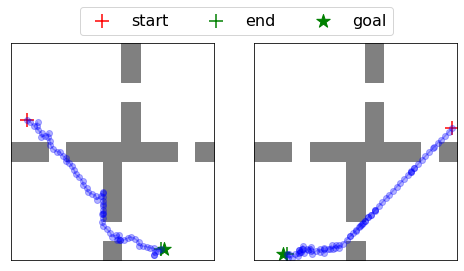

In [28]:
#@title Visualize rollouts. {run: "auto" }
eval_tf_env.pyenv.envs[0]._duration = 100  # We'll give the agent lots of time to try to find the goal.
difficulty = 0.6 #@param {min:0, max: 1, step: 0.1, type:"slider"}
max_goal_dist = eval_tf_env.pyenv.envs[0].gym.max_goal_dist
eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=1.0,
    min_dist=max(0, max_goal_dist * (difficulty - 0.05)),
    max_dist=max_goal_dist * (difficulty + 0.05))


def get_rollout(tf_env, policy, seed=None):
  np.random.seed(seed)  # Use the same task for both policies.
  obs_vec = []
  waypoint_vec = []
  ts = tf_env.reset()
  goal = ts.observation['goal'].numpy()[0]
  for _ in tqdm.tnrange(tf_env.pyenv.envs[0]._duration):
    obs_vec.append(ts.observation['observation'].numpy()[0])
    action = policy.action(ts)
    waypoint_vec.append(ts.observation['goal'].numpy()[0])
    ts = tf_env.step(action)
    if ts.is_last():
      break
  obs_vec.append(ts.observation['observation'].numpy()[0])
  obs_vec = np.array(obs_vec)
  waypoint_vec = np.array(waypoint_vec)
  return obs_vec, goal, waypoint_vec

plt.figure(figsize=(8, 4))
for col_index in range(2):
  plt.subplot(1, 2, col_index + 1)
  plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
  obs_vec, goal, _ = get_rollout(eval_tf_env, agent.policy)

  plt.plot(obs_vec[:, 0], obs_vec[:, 1], 'b-o', alpha=0.3)
  plt.scatter([obs_vec[0, 0]], [obs_vec[0, 1]], marker='+',
              color='red', s=200, label='start')
  plt.scatter([obs_vec[-1, 0]], [obs_vec[-1, 1]], marker='+',
              color='green', s=200, label='end')
  plt.scatter([goal[0]], [goal[1]], marker='*',
              color='green', s=200, label='goal')
  if col_index == 0:
    plt.legend(loc='lower left', bbox_to_anchor=(0.3, 1), ncol=3, fontsize=16)
plt.show()

We now will implement the search policy, which automatically finds these waypoints via graph search. The first step is to fill the replay buffer with random data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


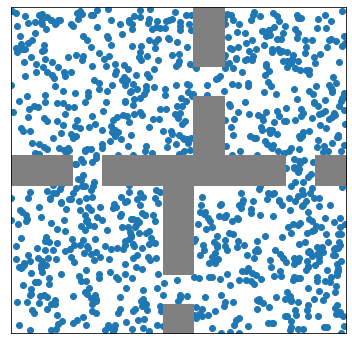

In [29]:
#@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
replay_buffer_size = 1000 #@param {min:100, max: 1000, step: 100, type:"slider"}

eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=0.0,
    min_dist=0,
    max_dist=np.inf)
rb_vec = []
for _ in tqdm.tnrange(replay_buffer_size):
  ts = eval_tf_env.reset()
  rb_vec.append(ts.observation['observation'].numpy()[0])
rb_vec = np.array(rb_vec)

plt.figure(figsize=(6, 6))
plt.scatter(*rb_vec.T)
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
plt.show()

As a sanity check, we'll plot the pairwise distances between all observations in the replay buffer. We expect to see a range of values from 1 to 20. Distributional RL implicitly caps the maximum predicted distance by the largest bin. We've used 20 bins, so the critic predicts 20 for all states that are at least 20 steps away from one another.

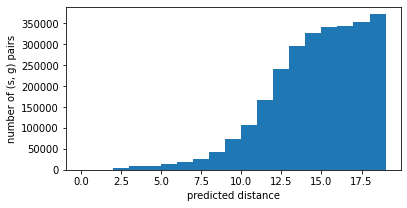

In [30]:
#@title Compute the pairwise distances { vertical-output: true}
pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()
plt.figure(figsize=(6, 3))
plt.hist(pdist.flatten(), bins=range(20))
plt.xlabel('predicted distance')
plt.ylabel('number of (s, g) pairs')
plt.show()

With these distances, we can construct a graph. Nodes in the graph are observations in our replay buffer. We connect observations with edges whose lengths are equal to the predicted distance between those observations. Since it is hard to visualize the edge lengths, we included a slider that allows you to only show edges whose predicted length is less than some threshold.

Our method learns a collection of critics, each of which makes an independent prediction for the distance between two states. Because each network may make bad predictions for pairs of states it hasn't seen before, we act in a *risk-averse* manner by using the maximum predicted distance across our ensemble. That is, we act pessimistically, only adding an edge if *all* critics think that this pair of states is nearby. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


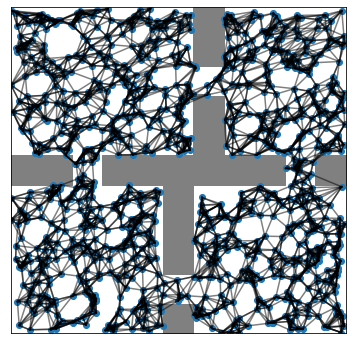

In [31]:
#@title Graph Construction { vertical-output: true, run: "auto" }
cutoff = 13 #@param {min:0, max: 20, type:"slider"}
# To make visualization easier, we only display the shortest edges for each
# node. We will use all edges for planning.
edges_to_display = 8
plt.figure(figsize=(6, 6))

plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
pdist_combined = np.max(pdist, axis=0)
plt.scatter(*rb_vec.T)
for i, s_i in enumerate(tqdm.tqdm_notebook(rb_vec)):
  for count, j in enumerate(np.argsort(pdist_combined[i])):
    if count < edges_to_display and pdist_combined[i, j] < cutoff:
      s_j = rb_vec[j]
      plt.plot([s_i[0], s_j[0]], [s_i[1], s_j[1]], c='k', alpha=0.5)

plt.show()

We can also visualize the predictions from each critic. Note that while each critic may make incorrect decisions for distant states, their predictions in aggregate are correct.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


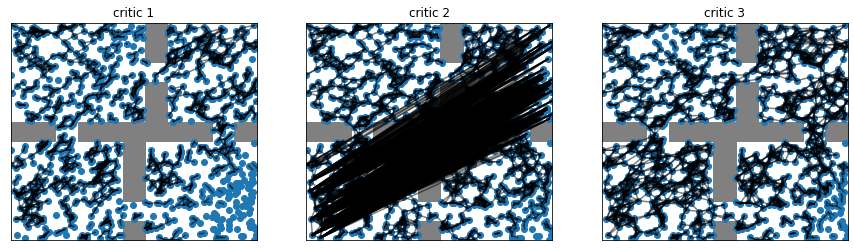

In [32]:
#@title Ensemble of Critics { vertical-output: true, run: "auto" }
cutoff = 5 #@param {min:0, max: 20, type:"slider"}
edges_to_display = 8
plt.figure(figsize=(15, 4))

for col_index in range(agent._ensemble_size):
  plt.subplot(1, agent._ensemble_size, col_index + 1)
  plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
  plt.title('critic %d' % (col_index + 1))

  plt.scatter(*rb_vec.T)
  desc='critic %d / %d' % (col_index + 1, agent._ensemble_size)
  for i, s_i in enumerate(tqdm.tqdm_notebook(rb_vec, desc=desc)):
    for count, j in enumerate(np.argsort(pdist[col_index, i])):
      if count < edges_to_display and pdist[col_index, i, j] < cutoff:
        s_j = rb_vec[j]
        plt.plot([s_i[0], s_j[0]], [s_i[1], s_j[1]], c='k', alpha=0.5)

plt.show()

### Search Policy
Now, we will combine the goal-conditioned policy and the distance estimates to form a search policy. Internally, this policy performs search over the replay buffer to find a set of waypoints leading to the goal. It then takes actions to reach each waypoint in turn. Because the search happens internally, this policy is a drop-in replacement for any other goal-conditioned policy.

We used a *closed loop* policy in our paper, recomputing the search path after each step. Below, we implement both the original closed loop version as well as an *open loop* version, which only performs search once at the start of the episode. The open loop version is much faster, but may perform worse in stochastic environments where replanning is important.

In [0]:
#@title Implement the search policy
class SearchPolicy(tf_policy.Base):

  def __init__(self, agent, open_loop=False):
    self._agent = agent
    self._open_loop = open_loop
    self._g = self._build_graph()
    super(SearchPolicy, self).__init__(agent.policy.time_step_spec,
                                       agent.policy.action_spec)

  def _build_graph(self):
    g = nx.DiGraph()
    pdist_combined = np.max(pdist, axis=0)
    for i, s_i in enumerate(rb_vec):
      for j, s_j in enumerate(rb_vec):
        length = pdist_combined[i, j]
        if length < self._agent._max_search_steps:
          g.add_edge(i, j, weight=length)
    return g

  def _get_path(self, time_step):
    start_to_rb = agent._get_pairwise_dist(ts.observation['observation'],
                                           rb_vec,
                                           aggregate='min',
                                           masked=True).numpy().flatten()
    rb_to_goal = agent._get_pairwise_dist(rb_vec,
                                          ts.observation['goal'],
                                          aggregate='min',
                                          masked=True).numpy().flatten()

    g2 = self._g.copy()
    for i, (dist_from_start, dist_to_goal) in enumerate(zip(start_to_rb, rb_to_goal)):
      if dist_from_start < self._agent._max_search_steps:
        g2.add_edge('start', i, weight=dist_from_start)
      if dist_to_goal < self._agent._max_search_steps:
        g2.add_edge(i, 'goal', weight=dist_to_goal)
    path = nx.shortest_path(g2, 'start', 'goal')
    edge_lengths = []
    for (i, j) in zip(path[:-1], path[1:]):
      edge_lengths.append(g2[i][j]['weight'])
    wypt_to_goal_dist = np.cumsum(edge_lengths[::-1])[::-1]  # Reverse CumSum
    waypoint_vec = list(path)[1:-1]
    return waypoint_vec, wypt_to_goal_dist[1:]

  def _action(self, time_step, policy_state=(), seed=None):
    goal = time_step.observation['goal']
    dist_to_goal = self._agent._get_dist_to_goal(time_step)[0].numpy()
    if self._open_loop:
      if time_step.is_first():
        self._waypoint_vec, self._wypt_to_goal_dist_vec = self._get_path(time_step)
        self._waypoint_counter = 0
      waypoint = rb_vec[self._waypoint_vec[self._waypoint_counter]]
      time_step.observation['goal'] = waypoint[None]
      dist_to_waypoint = self._agent._get_dist_to_goal(time_step)[0].numpy()
      if dist_to_waypoint < self._agent._max_search_steps:
        self._waypoint_counter = min(self._waypoint_counter + 1,
                                   len(self._waypoint_vec) - 1)
        waypoint = rb_vec[self._waypoint_vec[self._waypoint_counter]]
        time_step.observation['goal'] = waypoint[None]
        dist_to_waypoint = self._agent._get_dist_to_goal(time_step._replace())[0].numpy()
      dist_to_goal_via_wypt = dist_to_waypoint + self._wypt_to_goal_dist_vec[self._waypoint_counter]
    else:
      (waypoint, dist_to_goal_via_wypt) = self._agent._get_waypoint(time_step)
      dist_to_goal_via_wypt = dist_to_goal_via_wypt.numpy()

    if (dist_to_goal_via_wypt < dist_to_goal) or \
        (dist_to_goal > self._agent._max_search_steps):
      time_step.observation['goal'] = tf.convert_to_tensor(value=waypoint[None])
    else:
      time_step.observation['goal'] = goal
    return self._agent.policy.action(time_step, policy_state, seed)

Let's initialize the search policy:

In [0]:
agent.initialize_search(rb_vec, max_search_steps=7)
search_policy = SearchPolicy(agent, open_loop=True)

Now, let's plot the search path found by the search policy:

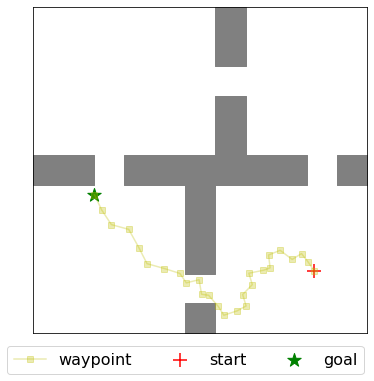

In [41]:
#@title Search Path. { vertical-output: false, run: "auto"}

difficulty = 0.5 #@param {min:0, max: 1, step: 0.1, type:"slider"}
max_goal_dist = eval_tf_env.pyenv.envs[0].gym.max_goal_dist
eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=1.0,
    min_dist=max(0, max_goal_dist * (difficulty - 0.05)),
    max_dist=max_goal_dist * (difficulty + 0.05))
ts = eval_tf_env.reset()
start = ts.observation['observation'].numpy()[0]
goal = ts.observation['goal'].numpy()[0]
search_policy.action(ts)

plt.figure(figsize=(6, 6))
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)

waypoint_vec = [start]
for waypoint_index in search_policy._waypoint_vec:
  waypoint_vec.append(rb_vec[waypoint_index])
waypoint_vec.append(goal)
waypoint_vec = np.array(waypoint_vec)

plt.scatter([start[0]], [start[1]], marker='+',
            color='red', s=200, label='start')
plt.scatter([goal[0]], [goal[1]], marker='*',
            color='green', s=200, label='goal')
plt.plot(waypoint_vec[:, 0], waypoint_vec[:, 1], 'y-s', alpha=0.3, label='waypoint')
plt.legend(loc='lower left', bbox_to_anchor=(-0.1, -0.15), ncol=4, fontsize=16)
plt.show()

Now, we'll use that path to guide the agent towards the goal. On the left, we plot rollouts from the baseline goal-conditioned policy. On the right, we use that same policy to reach each of the waypoints leading to the goal. As before, the slider allows you to change the distance to the goal. Note that only the search policy is able to reach distant goals.

In [0]:
#@title Rollouts with Search. { vertical-output: true, run: "auto"}
eval_tf_env.pyenv.envs[0]._duration = 300
seed = np.random.randint(0, 1000000)

difficulty = 0.8 #@param {min:0, max: 1, step: 0.1, type:"slider"}
max_goal_dist = eval_tf_env.pyenv.envs[0].gym.max_goal_dist
eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=1.0,
    min_dist=max(0, max_goal_dist * (difficulty - 0.05)),
    max_dist=max_goal_dist * (difficulty + 0.05))


plt.figure(figsize=(12, 5))
for col_index in range(2):
  title = 'no search' if col_index == 0 else 'search'
  plt.subplot(1, 2, col_index + 1)
  plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
  use_search = (col_index == 1)
  np.random.seed(seed)
  ts = eval_tf_env.reset()
  goal = ts.observation['goal'].numpy()[0]
  start = ts.observation['observation'].numpy()[0]
  obs_vec = []
  for _ in tqdm.tnrange(eval_tf_env.pyenv.envs[0]._duration,
                        desc='rollout %d / 2' % (col_index + 1)):
    if ts.is_last():
      break
    obs_vec.append(ts.observation['observation'].numpy()[0])
    if use_search:
      action = search_policy.action(ts)
    else:
      action = agent.policy.action(ts)

    ts = eval_tf_env.step(action)

  obs_vec = np.array(obs_vec)

  plt.plot(obs_vec[:, 0], obs_vec[:, 1], 'b-o', alpha=0.3)
  plt.scatter([obs_vec[0, 0]], [obs_vec[0, 1]], marker='+',
              color='red', s=200, label='start')
  plt.scatter([obs_vec[-1, 0]], [obs_vec[-1, 1]], marker='+',
              color='green', s=200, label='end')
  plt.scatter([goal[0]], [goal[1]], marker='*',
              color='green', s=200, label='goal')

  plt.title(title, fontsize=24)
  if use_search:
    waypoint_vec = [start]
    for waypoint_index in search_policy._waypoint_vec:
      waypoint_vec.append(rb_vec[waypoint_index])
    waypoint_vec.append(goal)
    waypoint_vec = np.array(waypoint_vec)

    plt.plot(waypoint_vec[:, 0], waypoint_vec[:, 1], 'y-s', alpha=0.3, label='waypoint')
    plt.legend(loc='lower left', bbox_to_anchor=(-0.8, -0.15), ncol=4, fontsize=16)
plt.show()

-----------------------------
## Next Steps and Open Problems
We encourage readers to play around with the experiments. To get started, here are a few questions:
1. What effect does distributional RL have on learning distances? (Hint: change `use_distributional_rl` when initializing the `UvfAgent`.)
2. What is the effect of using more critic networks in the ensemble? (Hint: change `ensemble_size` when initializing the `UvfAgent`)
3. While we applied planning *after* training a goal-conditioned policy, can planning be used to accelerate learning of the goal-conditioned policy? (Hint: Set `UvfAgent.collect_policy` to be the `SearchPolicy`)
4. Can you be smart about which observations to include in the replay buffer to make search faster? (Hint: Simple behavior cloning may be enough.)
7. Can the search policy be distilled into a single neural network policy?
5. What tricks are important for learning distances with RL?
6. How can more sophisticated planning algorithms be used in a similar framework?
8. Can the same idea by applied to other domains such, as manipulation?
